# Notebook for Automatic Evaluation of Final Model

This Notebook needs to be fed Model input and model output to evaluate
  - Semantic Preservation: Using Moverscore and comparing to baseline from PARANMT
  
**PLEASE INSTALL MOVERSCORE AS BELOW USING**
- https://drive.google.com/drive/folders/1SMHlJ338BHoJnkRiY-419EjLdFTHV91O?usp=sharing

Alternatively, please refer to https://github.com/AIPHES/emnlp19-moverscore


In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Setup


First, connecting to drive.

### Moverscore Setup

Please correct path to Moverscore requirements, if necessary!

In [2]:
path_to_moverscore = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/MoverScore/requirements.txt'
! pip3 install -r {path_to_moverscore}
! pip3 install transformers
! pip3 install pytorch-pretrained-bert
! pip3 install moverscore
! pip3 install tdqm

     |████████████████████████████████| 184kB 4.3MB/s 
     |████████████████████████████████| 133kB 22.2MB/s 
     |████████████████████████████████| 901kB 36.8MB/s 
     |████████████████████████████████| 1.2MB 32.0MB/s 
     |████████████████████████████████| 7.6MB 33.6MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
ERROR: botocore 1.20.97 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.5MB 4.3MB/s 
     |████████████████████████████████| 3.3MB 38.8MB/s 
     |████████████████████████████████| 133kB 4.0MB/s 
     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for moverscore: filename=moverscore-1.0.3-cp37-none-any.whl size=7968 sha256=667250d0718cab0f324d37b628b8ece06eb370e353ed7778bef03652a9eadecd
  Stored in directory: /root/.cache/pip/wheels/79/1b/3b/146bc744eef28d6c091b864fac8b76a7ffec5a694776c105f1
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any

  Created wheel for tdqm: filename=tdqm-0.0.1-cp37-none-any.whl size=1320 sha256=da9fa0cc7895676587f22ab341f0c2b3e7fda93e4c03c4f35bb1cc7faa76c6ab
  Stored in directory: /root/.cache/pip/wheels/d5/c0/4b/a98405d8b13071ab9a2be7beeef6820d26349ee46651c16a0d
Successfully built tdqm


In [3]:
# base_path_moverscore = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/MoverScoreBLEU/'

In [4]:
# Get Device 
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


In [5]:
## Use the original version with BERTMNLI to reproduce the results.
from moverscore import get_idf_dict, word_mover_score
## Recommend to use this version (DistilBERT) for evaluation, if the speed is your concern.
##from moverscore_v2 import get_idf_dict, word_mover_score 
from collections import defaultdict
import os
import pickle
import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import statistics
import string


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', -1)

[--------------------------------------------------]


### RoBERTa Setup

In [6]:
! pip install transformers==3
! pip install tokenizers

     |████████████████████████████████| 757kB 4.1MB/s 
     |████████████████████████████████| 3.0MB 8.2MB/s 
  Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Found existing installation: transformers 4.7.0
    Uninstalling transformers-4.7.0:
      Successfully uninstalled transformers-4.7.0


In [7]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import random


In [8]:
# Special RoBERTa mdoe to be used: While slight information might be lost; capitalization in tweets is a neglectable characteristic
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

- Get understanding of the distribution of token sizes for maximal length used in BERT

#### Build PyTorch Dataset and DataLoader

In [9]:
# Data Structure
class SentenceDataset(Dataset):
    def __init__(self, sents, labels, tokenizer, max_len):
        self.sents = sents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sents)
    
    def __getitem__(self, item):
        
        sent = str(self.sents[item])
        label = self.labels[item]

        encoding = tokenizer(sent,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = 'max_length',
                             max_length=self.max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
      
        return { 'sent': sent, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(sentences, labels, tokenizer, max_len = 100, batch_size= 32):
    ds = SentenceDataset(
        sents=sentences, #.to_numpy()
        labels=labels, #.to_numpy()
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

#### Actual Model

In [10]:
class StyleClassifier(nn.Module):
    def __init__(self, n_classes, drop = 0.3):
        
        super(StyleClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=drop)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

class StyleClassifier_forCluster(nn.Module):
    def __init__(self, n_classes, drop = 0.3):
        
        super(StyleClassifier_forCluster, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=drop)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output), pooled_output

#### Define Helper functions

In [11]:
# This provides just a way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix, names = ['Scientific', 'Non-Scientifc'], save_path = None):
  confusion_df = pd.DataFrame(cm, index=['Input', 'Output'],columns=['Non-Sci', 'Sci'])
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cbar=False, square=True,fmt='.2f')
  #plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  if save_path:
    plt.savefig(save_path)
  plt.show()

In [12]:
def get_predictions(model, data_loader):
  # put to eval mode to disable dropout 
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      _, preds = torch.max(outputs, dim=1) # dim BATCH_SIZE x 1

      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values, prediction_probs

In [13]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

#### Load model

Please Adjust model path if necessary

In [14]:
import datetime
day = datetime.date(2021, 6, 13)
MAX_LEN = 100 # chosen acccroding to hist above
BATCH_SIZE = 32# tunable hyper parameter
EPOCHS = 3
lr = 1e-5
dropout = 0.3

In [15]:
model_save_path = f'/content/gdrive/MyDrive/StyleClassifier/models/{day}/RoBERTA_Epochs{EPOCHS}_Bs{BATCH_SIZE}_lr{lr}_drop{dropout}/RoBERTa.bin'

model = StyleClassifier(2, drop = dropout).to(device)
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)

## Loading Model Input and Output


In [40]:
# Load paraphrases for calculation
data_path = '/content/gdrive/MyDrive/NLP_EvaluationMetrics/final_data/'
data_filename = 'evaluation_sample3000_GPT_M2.csv'
# Read model input and output
#with open(data_path+data_filename, 'rb') as f:
  #data = pickle.load(f)
data = pd.read_csv(data_path+data_filename)
data.head()

,Unnamed: 0,Unnamed: 0.1,sent,true_label,pred_label,prob0,prob1,prob_max,len,sent_masked,source,sent_output
0,0,102226,"therefore, for languages like chinese and japanese, which are written without spaces between words, tokenization boils down to string matching.",1,0,0.670159,0.416702,0.670159,29,"therefore, for <unk> like chinese and japanese, which are written without <unk> between <unk>, tokenization boils down to string matching.",cs_conf,"therefore, tokenization is a matter of language in which the word is written without spaces between words."
1,1,28200,"similar to these subtopics, feature representation is put as another important section deserving detailed descriptions, since feature representation, as an indispensable basis, is highly correlated with each of the three subtopics.",1,0,0.776326,0.337896,0.776326,40,"similar to these subtopics, <unk> <unk> is put as another important <unk> deserving detailed <unk>, since <unk> <unk>, as an indispensable <unk>, is highly correlated with each of the three subtopics.",cs_conf,"as an essential element for the three main components, the representation of the features is an important part of this subtopics in a detailed description, since the representation of these subtopics is highly correlated with each other."
2,2,75338,these clusters are ranked by collection selection to determine which clusters to search.,1,0,0.590534,0.567582,0.590534,14,these <unk> are ranked by <unk> <unk> to determine which <unk> to search.,cs_conf,"in order to determine which clusters to search, the collection selection is made."
3,3,100804,"however, the behavior network is realized by running some random process over the potential network which samples vertices and edges from it to produce the behavioral network and in some cases adds additional edges.",1,0,0.732323,0.412871,0.732323,38,"however, the <unk> <unk> is realized by running some <unk> <unk> over the potential <unk> which samples <unk> and <unk> from it to produce the <unk>al <unk> and in some <unk> adds additional <unk>.",cs_conf,"however, the behavior network is designed to run a random process to generate an individual network of vertices and edges, and sometimes it adds additional edges."
4,4,54387,"how well the code is performing, the percentage of potential instruction execution and memory bandwidth used by the kernel is output.",1,0,0.692315,0.452050,0.692315,23,"how well the <unk> is performing, the percentage of potential instruction <unk> and <unk> bandwidth used by the <unk> is <unk>.",cs_conf,"how well the code is working, how much work is involved in each operation and the amount of memory used by the kernel."


In [47]:
names = list(data.columns)
print(names)
names[2]='input'
names[-1]='output'
data.columns=names
data.head()

['Unnamed: 0', 'Unnamed: 0.1', 'sent', 'true_label', 'pred_label', 'prob0', 'prob1', 'prob_max', 'len', 'sent_masked', 'source', 'sent_output']


,Unnamed: 0,Unnamed: 0.1,input,true_label,pred_label,prob0,prob1,prob_max,len,sent_masked,source,output
0,0,102226,"therefore, for languages like chinese and japanese, which are written without spaces between words, tokenization boils down to string matching.",1,0,0.670159,0.416702,0.670159,29,"therefore, for <unk> like chinese and japanese, which are written without <unk> between <unk>, tokenization boils down to string matching.",cs_conf,"therefore, tokenization is a matter of language in which the word is written without spaces between words."
1,1,28200,"similar to these subtopics, feature representation is put as another important section deserving detailed descriptions, since feature representation, as an indispensable basis, is highly correlated with each of the three subtopics.",1,0,0.776326,0.337896,0.776326,40,"similar to these subtopics, <unk> <unk> is put as another important <unk> deserving detailed <unk>, since <unk> <unk>, as an indispensable <unk>, is highly correlated with each of the three subtopics.",cs_conf,"as an essential element for the three main components, the representation of the features is an important part of this subtopics in a detailed description, since the representation of these subtopics is highly correlated with each other."
2,2,75338,these clusters are ranked by collection selection to determine which clusters to search.,1,0,0.590534,0.567582,0.590534,14,these <unk> are ranked by <unk> <unk> to determine which <unk> to search.,cs_conf,"in order to determine which clusters to search, the collection selection is made."
3,3,100804,"however, the behavior network is realized by running some random process over the potential network which samples vertices and edges from it to produce the behavioral network and in some cases adds additional edges.",1,0,0.732323,0.412871,0.732323,38,"however, the <unk> <unk> is realized by running some <unk> <unk> over the potential <unk> which samples <unk> and <unk> from it to produce the <unk>al <unk> and in some <unk> adds additional <unk>.",cs_conf,"however, the behavior network is designed to run a random process to generate an individual network of vertices and edges, and sometimes it adds additional edges."
4,4,54387,"how well the code is performing, the percentage of potential instruction execution and memory bandwidth used by the kernel is output.",1,0,0.692315,0.452050,0.692315,23,"how well the <unk> is performing, the percentage of potential instruction <unk> and <unk> bandwidth used by the <unk> is <unk>.",cs_conf,"how well the code is working, how much work is involved in each operation and the amount of memory used by the kernel."


The next cell should not do anything, ideally

## Moverscore and BLEU4 

### Calculation

 The following cell will calculate MoverScore and BLEU4 from pairs of model input and output!


The data will be stored as 'model_input_output_with_scores.pkl'.

In [50]:
# datapath =

filename_dataframe = data_filename[:-4]+'_moverscore.csv'

try:
  # Try to read already calculated data
  data_scored =  pd.read_pickle(data_path + filename_dataframe)

except FileNotFoundError:
  print(f'Data does not exist yet! Calculating scores now ... ')


  # Setup data structure
  data_scored = pd.DataFrame(columns=['input', 'output', 'MoverScore', 'BLEU'])

  # Get idf dicts 
  idf_dict_hyp = get_idf_dict(data['input']) # idf_dict_hyp = defaultdict(lambda: 1.)
  idf_dict_ref = get_idf_dict(data['output']) # idf_dict_ref = defaultdict(lambda: 1.)

  # BLEU helpers
  translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  smoothie = SmoothingFunction().method4
  
  # calculate moverscores
  #THIS MIGHT BE IMPROVED WITH BETTER BATCHING
  for i, (ref, tran) in tqdm.notebook.tqdm(enumerate(zip(data['input'], data['output'])), total = len(data['output'])):

    # Calc Moverscore
    score_MS = word_mover_score([ref], [tran], idf_dict_ref, idf_dict_hyp, stop_words=[], n_gram=4, remove_subwords=True)
    
    # Calc BLEU
    try:
      score_BLEU = sentence_bleu(references=[ref.translate(translator).lower().split()], hypothesis=tran.translate(translator).lower().split(), weights=(.25, .25, .25, .25), smoothing_function=smoothie)

    except ZeroDivisionError:
      score_BLEU = None
       
    # Storing data in dataframe
    data_scored = data_scored.append(pd.DataFrame([[ref, tran, score_MS[0], score_BLEU]], 
                                              columns=['input', 'output', 'MoverScore', 'BLEU']),
                                              ignore_index=True)

  # After all sentences are done: Save data
  print('Saving data to :\t', data_path + filename_dataframe )
  data_scored.to_csv(data_path + filename_dataframe)

finally:
  print('Done!')

Data does not exist yet! Calculating scores now ... 



Saving data to :	 /content/gdrive/MyDrive/NLP_EvaluationMetrics/final_data/evaluation_sample3000_GPT_M2_moverscore.csv
Done!


In [51]:
print(f'Mean of BLEU', data_scored['BLEU'].mean())
print(f'Mean of MS', data_scored['MoverScore'].mean())

Mean of BLEU 0.22149832908442035
Mean of MS 0.5719492447805534


### Comparison to Baseline
In this section the distribution of Moverscores from the Model In- and Outputs is compared to that of a sample of the PARANMT dataset

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


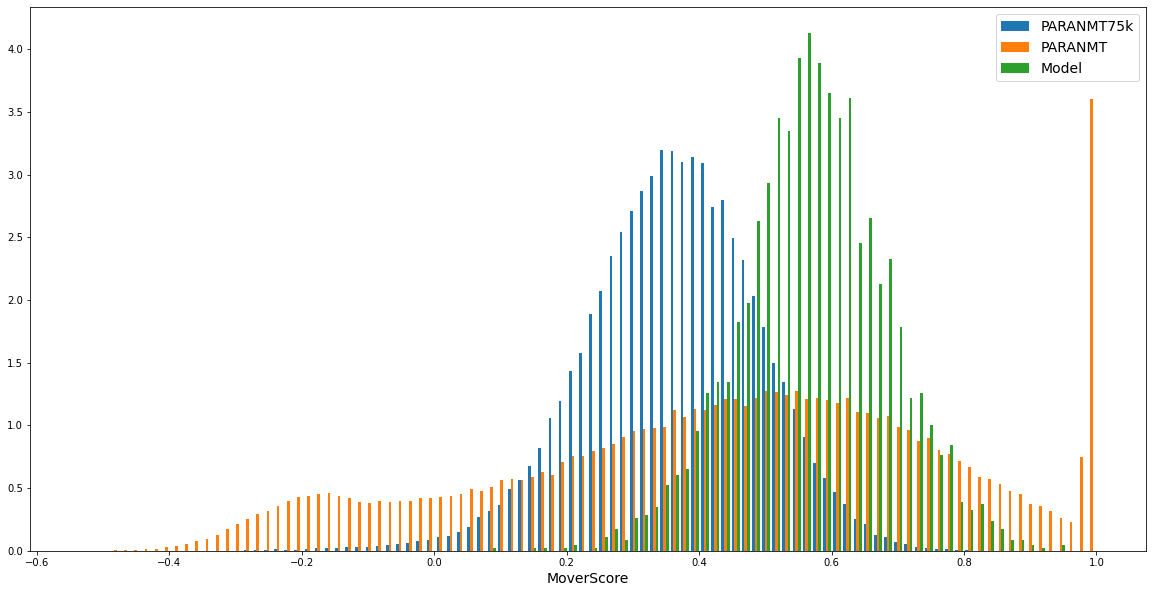

In [52]:
#Loading data for comparison
with open('/content/gdrive/MyDrive/NLP_EvaluationMetrics/paranmt_sampled/mover_scores_paranmt.pickle', 'rb') as f:
  moverscore_paranmt= pickle.load(f)
with open('/content/gdrive/MyDrive/NLP_EvaluationMetrics/paranmt_filtered/mover_scores.pickle', 'rb') as f:
  moverscore_paranmt75k= pickle.load(f)

fig, ax = plt.subplots(1,1, figsize = (20,10))

ax.hist([moverscore_paranmt75k, moverscore_paranmt, data_scored['MoverScore']], label = ['PARANMT75k','PARANMT', 'Model'], bins = 100, density = True)
ax.legend(fontsize = 14)
ax.set_xlabel('MoverScore', fontsize = 14)
plt.show()

**Conclusion:** The overall level of semantic preservation according to Moverscore is ...

## Style Transfer Evaluation using RoBERTa Model

In [ ]:
# Classifying input sentences
model_input_datalaoder = create_data_loader(data['input'].to_list(), [0 for _ in data['input']], tokenizer) #, MAX_LEN, BATCH_SIZE)

# Predict input and output sentences
labels_input_pred, _ ,_ = get_predictions(model, model_input_datalaoder)

data['input_label'] = labels_input_pred

In [ ]:
# Classifying input sentences
model_output_datalaoder = create_data_loader(data['output'].to_list(), [1 for _ in data['output']], tokenizer) #, MAX_LEN, BATCH_SIZE)

# Predict input and output sentences
labels_output_pred, _ ,_ = get_predictions(model, model_output_datalaoder)

data['output_label'] = labels_output_pred

In [ ]:
warnings.filterwarnings("ignore")
print(f'Total: {len(data)} sentences !')

cond = (data['input_label'] == data['output_label'])
print(f'Unchanged: {len(data[cond])} sentences !')

cond = (data['input_label'] == 0)*(data['output_label']==1)
cond2 = (data['input_label'] == 0)
print(f'Succesfully transferred: {len(data[cond])} sentences | {len(data[cond])/len(data[cond2]):.2f}% of unscientific sentences!')


cond = (data['input_label'] == 1)*(data['output_label']==0)
cond2 = (data['input_label'] == 1)
print(f'Wrongly transferred: {len(data[cond])} sentences | {len(data[cond])/len(data[cond2]):.2f}% of scientific sentences!')

Total: 104999 sentences !
Unchanged: 87345 sentences !
Succesfully transferred: 2466 sentences | 0.31% of unscientific sentences!
Wrongly transferred: 15188 sentences | 0.16% of scientific sentences!
